## Allowing language models to choose the right algorithm
In this notebook we enable a language model to choose the right algorithm for answering a specific question. We define multiple segmentation algorithms / tools and then give the language model the choice which one to use given different inputs.

In [1]:
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.tools import tool

from skimage.io import imread
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling, local_minima_seeded_watershed

import stackview

Again, we define an image storage and a list of tools.

In [2]:
image_storage = {}
tools = []

In [3]:
@tools.append
@tool
def load_image(filename:str):
    """Useful for loading and image file and storing it."""
    print("loading", filename)
    image = imread(filename)
    image_storage[filename] = image
    return "The image is now stored as " + filename

We define two segmentation algorithms, one for segmenting bright objects and one for segmenting dark objects.

In [4]:
@tools.append
@tool
def segment_bright_objects(image_name):
    """
    Useful for segmenting bright objects in an image 
    that has been loaded and stored before.
    """
    print("segmenting (Voronoi-Otsu-Labeling)", image_name)
    
    image = image_storage[image_name]
    label_image = voronoi_otsu_labeling(image, spot_sigma=4)
    
    label_image_name = "segmented_" + image_name
    image_storage[label_image_name] = label_image
    
    return "The segmented image has been stored as " + label_image_name

In [5]:
@tools.append
@tool
def segment_dark_objects(image_name):
    """
    Useful for segmenting dark objects with bright border in an image 
    that has been loaded and stored before.
    """
    print("segmenting (Local-minima-seeded watershed)", image_name)
    
    image = image_storage[image_name]
    label_image = local_minima_seeded_watershed(image, spot_sigma=10)
    
    label_image_name = "segmented_" + image_name
    image_storage[label_image_name] = label_image
    
    return "The segmented image has been stored as " + label_image_name

In [6]:
@tools.append
@tool
def show_image(image_name):
    """Useful for showing an image that has been loaded and stored before."""
    print("showing", image_name)
    
    image = image_storage[image_name]
    display(stackview.insight(image))
    
    return "The image " + image_name + " is shown above."

We create some memory and a large language model based on OpenAI's chatGPT.

In [7]:
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
llm=ChatOpenAI(temperature=0)

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


Given the list of tools, the large language model and the memory, we can create an agent.

In [8]:
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION, 
    memory=memory
)

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


This agent can then respond to prompts.

In [9]:
agent.run("Please load the image 'data/membrane2d.tif' and show it.")

C:\Users\haase\mambaforge\envs\tea3\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


loading data/membrane2d.tif


"The image 'data/membrane2d.tif' has been successfully loaded and stored."

In [10]:
agent.run("Please segment the image 'data/membrane2d.tif'")

segmenting (Voronoi-Otsu-Labeling) data/membrane2d.tif


'The segmented image has been stored as segmented_data/membrane2d.tif'

showing segmented_data/membrane2d.tif


StackViewNDArray([[ 6,  6,  6, ...,  0,  0,  0],
                  [ 6,  6,  6, ...,  0,  0,  0],
                  [ 6,  6,  6, ...,  0,  3,  3],
                  ...,
                  [ 0,  0,  0, ..., 55, 55, 55],
                  [ 0,  0,  0, ..., 55, 55, 55],
                  [ 0,  0,  0, ..., 55, 55, 55]])
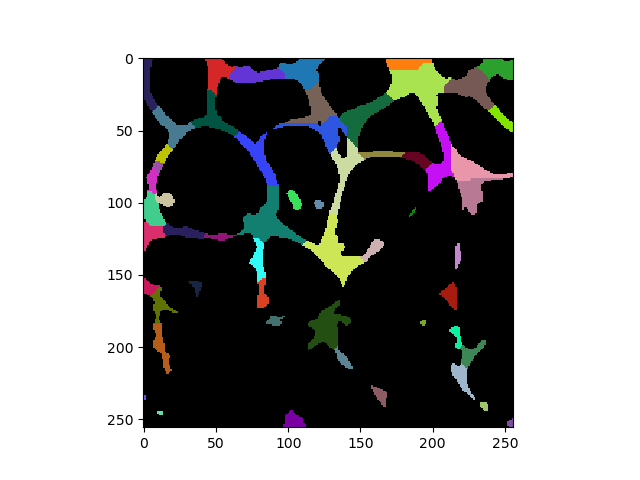

'The image segmented_data/membrane2d.tif is shown above.'

In [11]:
agent.run("Please show the segmented 'data/membrane2d.tif' image.")

The segmentation does not look like a cell-segmentation. Thus, we should ask more specifically.

In [12]:
agent.run("Please segment the image 'data/membrane2d.tif' again and this time, segment the dark cells surrounded by bright membranes. Also show the result of the segmentation.")

segmenting (Local-minima-seeded watershed) data/membrane2d.tif


'The segmented image has been stored as segmented_data/membrane2d.tif'

We can also ask the agent which algorithm it chose and why it chose this tool.

In [13]:
agent.run("Which algorithm did you use this time?")

'segment_dark_objects'

In [14]:
agent.run("Why did you use this algorithm?")

"I used the 'segment_dark_objects' algorithm to segment dark objects with bright borders in the image 'data/membrane2d.tif'."

Note: The language model cannot see the image. Its tool-selection depends on information you provided and information it acquired during the chat.

## Exercise
Copy the image file "membrane2d.tif" and name it "image.tif". Run the procedure above again. Which influence does the filename have on results?